# Lecture Notes 3: Rounding, Overflow, Linear Algebra

## Rounding

Let's start with a weird experiment:

In [1]:
import numpy
a = numpy.array([1,10,100,1000],dtype='float32')
print(a)

[    1.    10.   100.  1000.]


In [2]:
print((a+1000000000.0)-1000000000.0)

[    0.     0.   128.  1024.]


Now, let's repeat the experiment with higher precision (`float64`):

In [3]:
import numpy
a = numpy.array([1,10,100,1000],dtype='float64')
print(a)

[    1.    10.   100.  1000.]


In [4]:
print((a+1000000000.0)-1000000000.0)

[    1.    10.   100.  1000.]


We can also reach the limits of `float64`:

In [5]:
print((a+1000000000000000000.0)-1000000000000000000.0)

[    0.     0.   128.  1024.]


### Understanding of rounding effect

In [6]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png')
plt.rcParams['savefig.dpi'] = 90

We plot all numbers before and after application of the addition and substraction:

Text(0,0.5,'after')

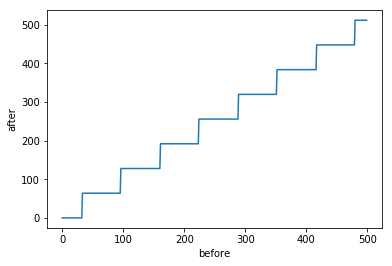

In [7]:
a = numpy.arange(500).astype('float32')
b = (a + 1000000000.0) - 1000000000.0
plt.plot(a,b); plt.xlabel('before'); plt.ylabel('after')

Text(0,0.5,'after')

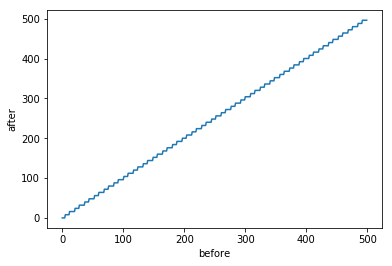

In [8]:
a = numpy.arange(500).astype('float32')
b = (a + 100000000.0) - 100000000.0
plt.plot(a,b); plt.xlabel('before'); plt.ylabel('after')

### Comments

* The `float32` and `float64` number representations have a certain budget of bits to represent all numbers in the world. Therefore, they allocate precision where it is important (e.g. for small numbers).

* The smaller the precision, the smallest the space on the memory and therefore the more efficient, but also the more careful we should be about potential loss of precision.

* Unlike typical observed data, error is not random-looking, but very structured:

Text(0,0.5,'output error')

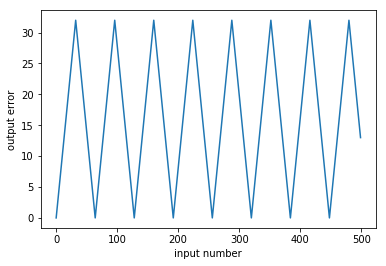

In [9]:
a = numpy.arange(500).astype('float32')
error = numpy.abs(a-((a + 1000000000.0) - 1000000000.0))
plt.plot(a,error); plt.xlabel('input number'); plt.ylabel('output error')

## Overflow

Overflow is a frequently encountered problem when implementing machine learning algorithms.

In [10]:
a = numpy.array([1,10,100,1000],dtype='float32')

print(numpy.exp(a))

[  2.71828175e+00   2.20264648e+04              inf              inf]


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


### The sigmoid function

![plot generated by fooplot.com](sigmoid.png)

$$
\mathrm{sigmoid}(x) = \frac{\exp(x)}{1+\exp(x)}
$$

In [11]:
X = numpy.array([-1e9,-1e6,-1e3,-1e1,2,1,0,1,2,1e1,1e3,1e6,1e9],dtype='float32')

def sigmoid(x): return numpy.exp(x) / (1+numpy.exp(x))

print(sigmoid(X))

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   4.53978682e-05
   8.80797088e-01   7.31058598e-01   5.00000000e-01   7.31058598e-01
   8.80797088e-01   9.99954581e-01              nan              nan
              nan]


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


Where does the `nan` comes from:

In [12]:
print(numpy.exp(1000))

inf


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


In [13]:
print(float('inf') / float('inf'))

nan


### The sigmoid function (2)

Let's rewrite the sigmoid function in a different way

$$
\mathrm{sigmoid}(x) = \frac{\exp(x)}{1+\exp(x)} = \frac{\exp(-x) \exp(x)}{\exp(-x) (1+\exp(x))} = \frac{1}{1+\exp(-x)}
$$

In [14]:
def sigmoid(x): return 1 / (1+numpy.exp(-x))

sigmoid(X)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         4.53978719e-05,   8.80797029e-01,   7.31058598e-01,
         5.00000000e-01,   7.31058598e-01,   8.80797029e-01,
         9.99954581e-01,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00], dtype=float32)

Here, we still get an overflow. But this time, we are lucky since 1/inf = 0.0, which is the desired result for very negative inputs.

In [28]:
1.0 / float('inf')


0.0

### The sigmoid function (3)


The sigmoid function can be written in yet another way:
$$
\mathrm{sigmoid}(x) = \frac{\exp(x)}{1+\exp(x)} = 0.5 \tanh(0.5 x) + 0.5
$$

In [16]:
def sigmoid(x): return 0.5*numpy.tanh(0.5*x)+0.5

sigmoid(X)

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         4.53889370e-05,   8.80797088e-01,   7.31058598e-01,
         5.00000000e-01,   7.31058598e-01,   8.80797088e-01,
         9.99954581e-01,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00], dtype=float32)

And there is no runtime warning this time.

### The sigmoid function (4)

Suppose we cannot use the tanh function. The sigmoid function can be approximated to avoid the overflow:

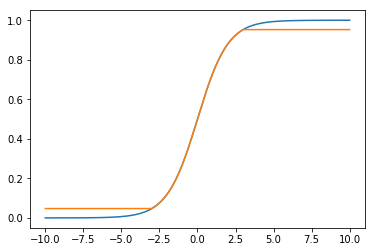

In [17]:
X = numpy.arange(-10,10.01,0.1)

plt.plot(X,sigmoid(X))

plt.plot(X,sigmoid(numpy.clip(X,-3,3)))

The numpy clip function prevents the input from going outside a certain interval. This effectively avoids overflow in the exponential, but also incurs a small approximation error.

### Another source of overflow: normalizing probability distributions

Many probability functions can be written this way:
$$
p(x) = \frac1Z \exp(f(x))
$$

* Example of such functions: Gaussian distribution, Gibbs distribution.

* Machine learning algorithms often use these distributions, because their parameters can be learned easily. For example, the mean parameter of a Gaussian distribution can be learned by computing the mean of the data, and the scale parameter can be learned by computing the standard deviation.

* On the other hand, these probability functions have a risk of overflow due to the exponential.

In [18]:
# Let p(x) be a discrete distribution with function values
f = numpy.array([1.0,8.0,100.0,0.1,3.5,2.3],dtype='float32')

# The normalization factor is the sum of these function values
# after application of the exponential function
Z = numpy.exp(f).sum()

print(Z)

inf


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp


Even taking the logarithm of `Z` won't solve the overflow.

In [19]:
print(numpy.log(Z))

inf


This problem will be studied in the homework.

## Linear Algebra

Many machine learning techniques are based on linear algebra. Two important ones are linear regression and principal component analysis. These techniques can be implemented easily in Python and numpy.

### Linear regression

Finding the best linear fit of a labeled dataset.

Text(0,0.5,'y')

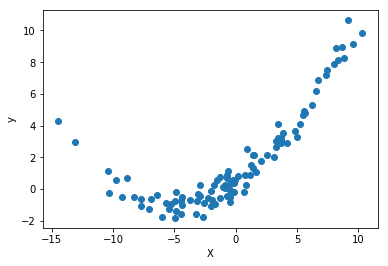

In [20]:
# Create a dataset
X = numpy.concatenate([numpy.random.normal(0,5,[100,1]),numpy.ones([100,1])],axis=1)

# Create outputs and make them depend on X in some way
y = 0.5*X[:,0]+0.05*X[:,0]**2 + 0.5 + numpy.random.normal(0,0.5,[100])

# Plot the labeled dataset
plt.scatter(X[:,0],y); plt.xlabel('X'); plt.ylabel('y')

The parameter of the model is given by:
$$\beta = (X^\top X)^{-1} X^\top y$$

And the prediction for new "test" points by:
$$\hat y_\text{test} = X_\text{test} \beta$$

Text(0,0.5,'y')

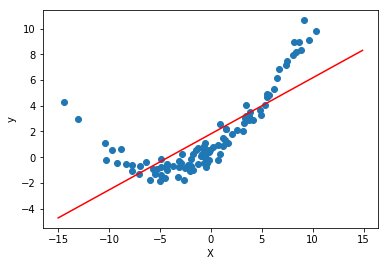

In [21]:
import numpy.linalg

# Learn the model parameter
beta = numpy.dot(numpy.dot(numpy.linalg.inv(numpy.dot(X.T,X)),X.T),y)

# Predict some test data
Xtest = numpy.arange(-15,15,0.1)
Xtest = numpy.array([Xtest,Xtest*0+1]).T
ytest = numpy.dot(Xtest,beta)

# Plot the data and the prediction
plt.figure()
plt.scatter(X[:,0],y); plt.xlabel('X'); plt.ylabel('y')
plt.plot(Xtest[:,0],ytest,color='red'); plt.xlabel('X'); plt.ylabel('y')

### Principal component analysis (PCA)

Find the most salient direction in a multidimensional unlabeled dataset.

[-30, 30, -30, 30]

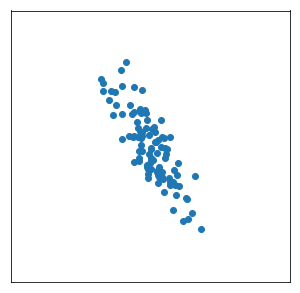

In [22]:
# create a random dataset
X = numpy.random.normal(0,5,[100,2])

# create some relation between dimensions
X[:,1] = X[:,1] - 1.5*X[:,0]

# PCA only applies to centered data, so we center the data
X -= X.mean(axis=0)

# Plot the centered dataset
plt.figure(figsize=(5,5))
plt.scatter(*X.T)
plt.xticks([]); plt.yticks([])
plt.axis([-30,30,-30,30])

[-30, 30, -30, 30]

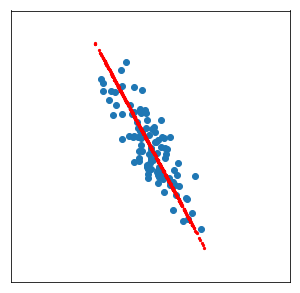

In [23]:
# Find the principal components
U,W,V = numpy.linalg.svd(X)
HAT = numpy.outer(V[0],V[0])

# Project some test data on the principal compenent
Xtest    = numpy.random.uniform(-20,20,[500,2])
XtestPCA = numpy.dot(Xtest,HAT)

# Plot the original data and the projected test data
plt.figure(figsize=(5,5))
plt.scatter(*X.T)
plt.scatter(*XtestPCA.T,color='red',s=5)
plt.xticks([]); plt.yticks([])
plt.axis([-30,30,-30,30])